In [ ]:
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
from matplotlib.colors import ListedColormap


In [ ]:
def hex_to_rgb(value):
    value = value.lstrip('#')
    return tuple(int(value[i:i+2], 16)/255 for i in (0, 2, 4))

In [ ]:
color1 = hex_to_rgb("#ffffff")  # white
color2 = hex_to_rgb("#79c064")  # green

# Create a gradient with 256 steps
gradient = np.linspace(0, 1, 256)
colors = [(
    color1[0] + (color2[0]-color1[0])*x,
    color1[1] + (color2[1]-color1[1])*x,
    color1[2] + (color2[2]-color1[2])*x
) for x in gradient]

wg_cmap = ListedColormap(colors, name="white_green")

In [11]:
# Define the three colors in HEX
colors_hex = ['#6b8ae0', '#ffffff', '#da6290']

# Convert all colors to RGB
colors_rgb = [hex_to_rgb(c) for c in colors_hex]

# Create gradient with 256 steps
n_bins = 256  # Number of discrete colors in the colormap
cmap_name = 'blue_white_pink'

# Create the colormap
gradient = np.linspace(0, 1, n_bins)
colors = []
for x in gradient:
    if x < 0.5:  # First half: blue to white
        t = x * 2  # Scale to 0-1
        r = colors_rgb[0][0] + (colors_rgb[1][0] - colors_rgb[0][0]) * t
        g = colors_rgb[0][1] + (colors_rgb[1][1] - colors_rgb[0][1]) * t
        b = colors_rgb[0][2] + (colors_rgb[1][2] - colors_rgb[0][2]) * t
    else:  # Second half: white to pink
        t = (x - 0.5) * 2  # Scale to 0-1
        r = colors_rgb[1][0] + (colors_rgb[2][0] - colors_rgb[1][0]) * t
        g = colors_rgb[1][1] + (colors_rgb[2][1] - colors_rgb[1][1]) * t
        b = colors_rgb[1][2] + (colors_rgb[2][2] - colors_rgb[1][2]) * t
    colors.append((r, g, b))

bwp_cmap = ListedColormap(colors, name=cmap_name)

# ONSEN methylation heatmaps
## TE body

In [6]:
results_dict = {}
for key in ['Col-0', '12-1', '1-1', '3-6', '7-5', '13-1', '14-2']:
    for context in ['CG', 'CHG', 'CHH']:
        results_dict[f'{key}_{context}'] = pd.read_csv(f'ONSENs_meth_bins/ONSEN_binned_methylation_{key}_{context}.csv')

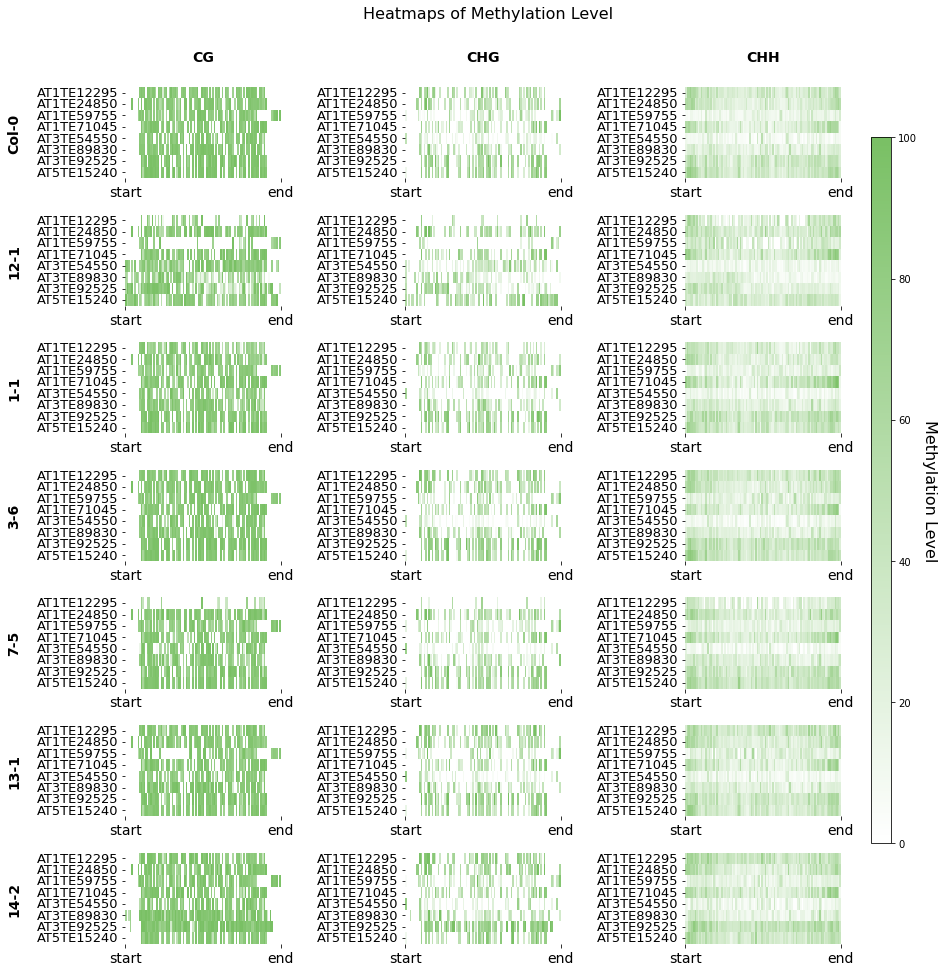

In [10]:
# Define global min and max values for the color scale
vmin = min(df.iloc[:, 1:].min().min() for df in results_dict.values())  # Global minimum value
vmax = max(df.iloc[:, 1:].max().max() for df in results_dict.values())  # Global maximum value

# Calculate heights for each subplot based on the number of rows in the DataFrame
heights = [len(df) for df in results_dict.values()][::3]  # Heights based on number of rows
total_height = sum(heights)  # Total height for normalization

# Create a figure with more space
fig = plt.figure(figsize=(14, 14))
fig.suptitle('Heatmaps of Methylation Level', fontsize=16, y=0.98)

# Create GridSpec with proper spacing
gs = fig.add_gridspec(7, 3, height_ratios=heights, hspace=0.4, wspace=0.8, 
                      left=0.14, right=0.85, top=0.9, bottom=0.05)

# Create axes using the GridSpec
axes = []
for i in range(7):
    for j in range(3):
        axes.append(fig.add_subplot(gs[i, j]))

# Define column titles (CG, CHG, CHH)
col_titles = ['CG', 'CHG', 'CHH']

# Define row titles (sample names)
row_titles = ['Col-0', '12-1', '1-1', '3-6', '7-5', '13-1', '14-2']  # Sample names from ins_dict

# Iterate through the results_diff_dict and plot each heatmap in a subplot
for i, (name, df) in enumerate(results_dict.items()):
    # Plot the heatmap in the current subplot
    heatmap = sns.heatmap(
        df.iloc[:, 1:], 
        cmap=wg_cmap, 
        ax=axes[i], 
        cbar=False,  # Disable individual color bars
        vmin=vmin,  # Use global min for color scale
        vmax=vmax   # Use global max for color scale
    )
    
    # Set y-ticks in the center of bins
    yticks = np.arange(len(df)) + 0.5  # Offset by 0.5 to center the ticks
    axes[i].set_yticks(yticks)
    axes[i].set_yticklabels(df['ONSEN'], fontsize=13, rotation=0, va='center')  # Use 'insertion' column for y-tick labels
    
    # Remove x and y labels
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    
    # Customize x-ticks
    axes[i].set_xticks([0, 100])  # Positions for -1000bp, TEI, +1000bp (aligned to edges)
    axes[i].set_xticklabels(['start', 'end'], fontsize=14, rotation=0)

# Get the positions of the subplots after they've been created
fig.canvas.draw()  # This is needed to ensure the positions are calculated
pos = []
for ax in axes:
    pos.append(ax.get_position())

# Add column titles (CG, CHG, CHH)
for j in range(3):
    # Calculate the center position for each column
    x_center = (pos[j].x0 + pos[j].x1) / 2
    fig.text(
        x_center, 0.93, col_titles[j],
        ha='center', va='center', fontsize=14, fontweight='bold'
    )

# Add row titles (sample names)
for k in range(7):
    # Calculate the center position for each row
    y_center = (pos[k*3].y0 + pos[k*3].y1) / 2
    fig.text(
        0.03, y_center, row_titles[k],
        ha='center', va='center', fontsize=14, fontweight='bold', rotation=90
    )

# Add a single color bar for the entire figure
cbar_ax = fig.add_axes([0.88, 0.15, 0.02, 0.7])  # Adjusted position for the color bar
cbar = plt.colorbar(heatmap.get_children()[0], cax=cbar_ax)
cbar.set_label('Methylation Level', rotation=270, labelpad=20, fontsize=16)

# Save the figure
plt.savefig('plots/ONSENs_binned_methylation.svg', bbox_inches='tight', dpi=300)

## TE flanks

In [44]:
results_flank_dict = {}
for key in ['Col-0', '12-1', '1-1', '3-6', '7-5', '13-1', '14-2']:
    for context in ['CG', 'CHG', 'CHH']:
        results_flank_dict[f'{key}_{context}'] = pd.read_csv(f'ONSENs_flanks/ONSEN_flanking_methylation_{key}_{context}.csv')

results_flank_dict_mean = {}
for key, df in results_flank_dict.items():
    results_flank_dict_mean[key] = df.groupby('ONSEN').mean().reset_index()

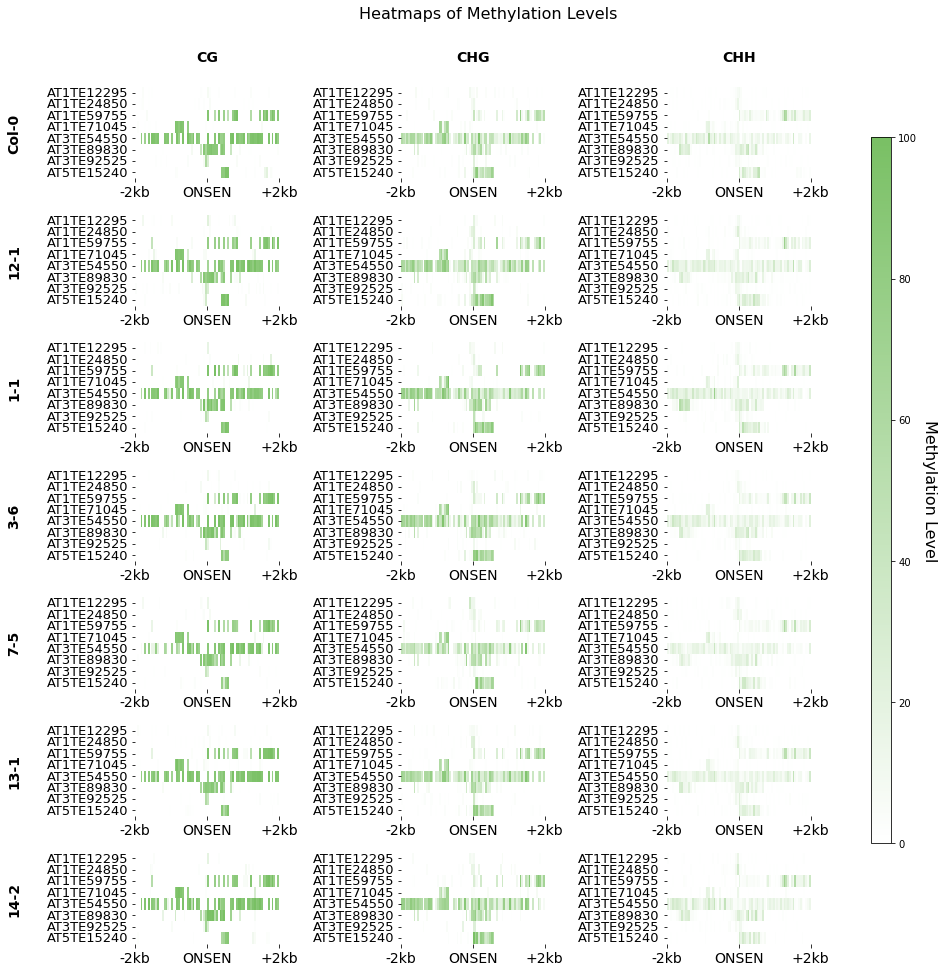

In [14]:
# Define global min and max values for the color scale
vmin = min(df.iloc[:, 1:].min().min() for df in results_flank_dict_mean.values())  # Global minimum value
vmax = max(df.iloc[:, 1:].max().max() for df in results_flank_dict_mean.values())  # Global maximum value

# Calculate heights for each subplot based on the number of rows in the DataFrame
heights = [len(df) for df in results_flank_dict_mean.values()][::3]  # Heights based on number of rows
total_height = sum(heights)  # Total height for normalization

# Create a figure with more space
fig = plt.figure(figsize=(14, 14))
fig.suptitle('Heatmaps of Methylation Levels', fontsize=16, y=0.98)

# Create GridSpec with proper spacing
gs = fig.add_gridspec(7, 3, height_ratios=heights, hspace=0.4, wspace=0.85, 
                      left=0.15, right=0.82, top=0.9, bottom=0.05)

# Create axes using the GridSpec
axes = []
for i in range(7):
    for j in range(3):
        axes.append(fig.add_subplot(gs[i, j]))

# Define column titles (CG, CHG, CHH)
col_titles = ['CG', 'CHG', 'CHH']

# Define row titles (sample names)
row_titles = ['Col-0', '12-1', '1-1', '3-6', '7-5', '13-1', '14-2']  # Sample names from ins_dict

# Iterate through the results_diff_dict and plot each heatmap in a subplot
for i, (name, df) in enumerate(results_flank_dict_mean.items()):
    # Plot the heatmap in the current subplot
    heatmap = sns.heatmap(
        df.iloc[:, 1:], 
        cmap=wg_cmap, 
        ax=axes[i], 
        cbar=False,  # Disable individual color bars
        vmin=vmin,  # Use global min for color scale
        vmax=vmax   # Use global max for color scale
    )
    
    # Set y-ticks in the center of bins
    yticks = np.arange(len(df)) + 0.5  # Offset by 0.5 to center the ticks
    axes[i].set_yticks(yticks)
    axes[i].set_yticklabels(df['ONSEN'], fontsize=13, rotation=0, va='center')  # Use 'insertion' column for y-tick labels
    
    # Remove x and y labels
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    
    # Customize x-ticks
    axes[i].set_xticks([0, 40, 80])  # Positions for -1000bp, TEI, +1000bp (aligned to edges)
    axes[i].set_xticklabels(['-2kb', 'ONSEN', '+2kb'], fontsize=14, rotation=0)

# Get the positions of the subplots after they've been created
fig.canvas.draw()  # This is needed to ensure the positions are calculated
pos = []
for ax in axes:
    pos.append(ax.get_position())

# Add column titles (CG, CHG, CHH)
for j in range(3):
    # Calculate the center position for each column
    x_center = (pos[j].x0 + pos[j].x1) / 2
    fig.text(
        x_center, 0.93, col_titles[j],
        ha='center', va='center', fontsize=14, fontweight='bold'
    )

# Add row titles (sample names)
for k in range(7):
    # Calculate the center position for each row
    y_center = (pos[k*3].y0 + pos[k*3].y1) / 2
    fig.text(
        0.03, y_center, row_titles[k],
        ha='center', va='center', fontsize=14, fontweight='bold', rotation=90
    )

# Add a single color bar for the entire figure
cbar_ax = fig.add_axes([0.88, 0.15, 0.02, 0.7])  # Adjusted position for the color bar
cbar = plt.colorbar(heatmap.get_children()[0], cax=cbar_ax)
cbar.set_label('Methylation Level', rotation=270, labelpad=20, fontsize=16)

# Save the figure
plt.savefig('plots/ONSEN_flanking_methylation_2kb.svg', bbox_inches='tight', dpi=300)

# TEI methylation heatmaps
## TEI body

In [45]:
# Function to extract chromosome, start, and end from the insertion/TEIcoord string
def extract_coords(coord_str):
    match = re.match(r'([^:]+):(\d+)\.\.(\d+)', coord_str)
    if match:
        chr_name = match.group(1)
        start = int(match.group(2))
        end = int(match.group(3))
        return chr_name, start, end
    return None, None, None

In [46]:
results_tei_dict = {}

for key in ['Col-0', '12-1', '1-1', '3-6', '7-5', '13-1', '14-2']:
    for context in ['CG', 'CHG', 'CHH']:
        results_df = pd.read_csv(f'TEI_meth_bins/TEI_binned_methylation_{key}_{context}.csv')
        results_tei_dict[f'{key}_{context}'] = results_df

In [47]:
tei_ori = pd.read_csv('TEI_S1_orientation.tsv', sep='\t')

In [48]:
match_dfs = {'12-1': pd.DataFrame(tei_ori[tei_ori['sample']=='SQK-NBD114-96_barcode01']), 
            '1-1': pd.DataFrame(tei_ori[tei_ori['sample']=='SQK-NBD114-96_barcode19']),
            '3-6': pd.DataFrame(tei_ori[tei_ori['sample']=='SQK-NBD114-96_barcode20']),
            '7-5': pd.DataFrame(tei_ori[tei_ori['sample']=='SQK-NBD114-96_barcode21']),
            '13-1': pd.DataFrame(tei_ori[tei_ori['sample']=='SQK-NBD114-96_barcode22']),
            '14-2': pd.DataFrame(tei_ori[tei_ori['sample']=='SQK-NBD114-96_barcode23'])
            }

In [49]:
matched_dfs = {}

# Define a tolerance for start/end positions (e.g., ±5 bp)
TOLERANCE = 30
for key in ['12-1', '1-1', '3-6', '7-5', '13-1', '14-2']:
    df2 = match_dfs[key]

    # Add extracted coordinates to df2
    df2[['chr', 'start', 'end']] = df2['TEIcoord'].apply(extract_coords).apply(pd.Series)

    for context in ['CG', 'CHG', 'CHH']:
        df1 = results_tei_dict[f'{key}_{context}'] 
        
        # Add extracted coordinates to df1
        df1[['chr', 'start', 'end']] = df1['TEI'].apply(extract_coords).apply(pd.Series)


        # Merge df1 and df2 based on fuzzy matching of coordinates
        merged_df = pd.merge(
            df1,
            df2,
            on='chr',  # Match by chromosome
            suffixes=('_df1', '_df2')
        )

        # Filter rows where start and end positions are within the tolerance
        merged_df = merged_df[
            (abs(merged_df['start_df1'] - merged_df['start_df2']) <= TOLERANCE) &
            (abs(merged_df['end_df1'] - merged_df['end_df2']) <= TOLERANCE)
        ]

        # Drop unnecessary columns
        merged_df = merged_df.drop(columns=['chr', 'start_df1', 'end_df1', 'start_df2', 'end_df2'])

        # Reorder columns for clarity
        merged_df = merged_df[['TEI', 'TEIcoord', 'sample', 'zygoticity', 'orientaion_TEI', 'orientation_gene', 'consistency'] + 
                        [col for col in merged_df.columns if col.startswith('bin_')]]
        merged_df.to_csv(f'TEI_meth_bins/TEI_binned_methylation_{key}_{context}_ori.csv', index=False)
        matched_dfs[f'{key}_{context}'] = merged_df

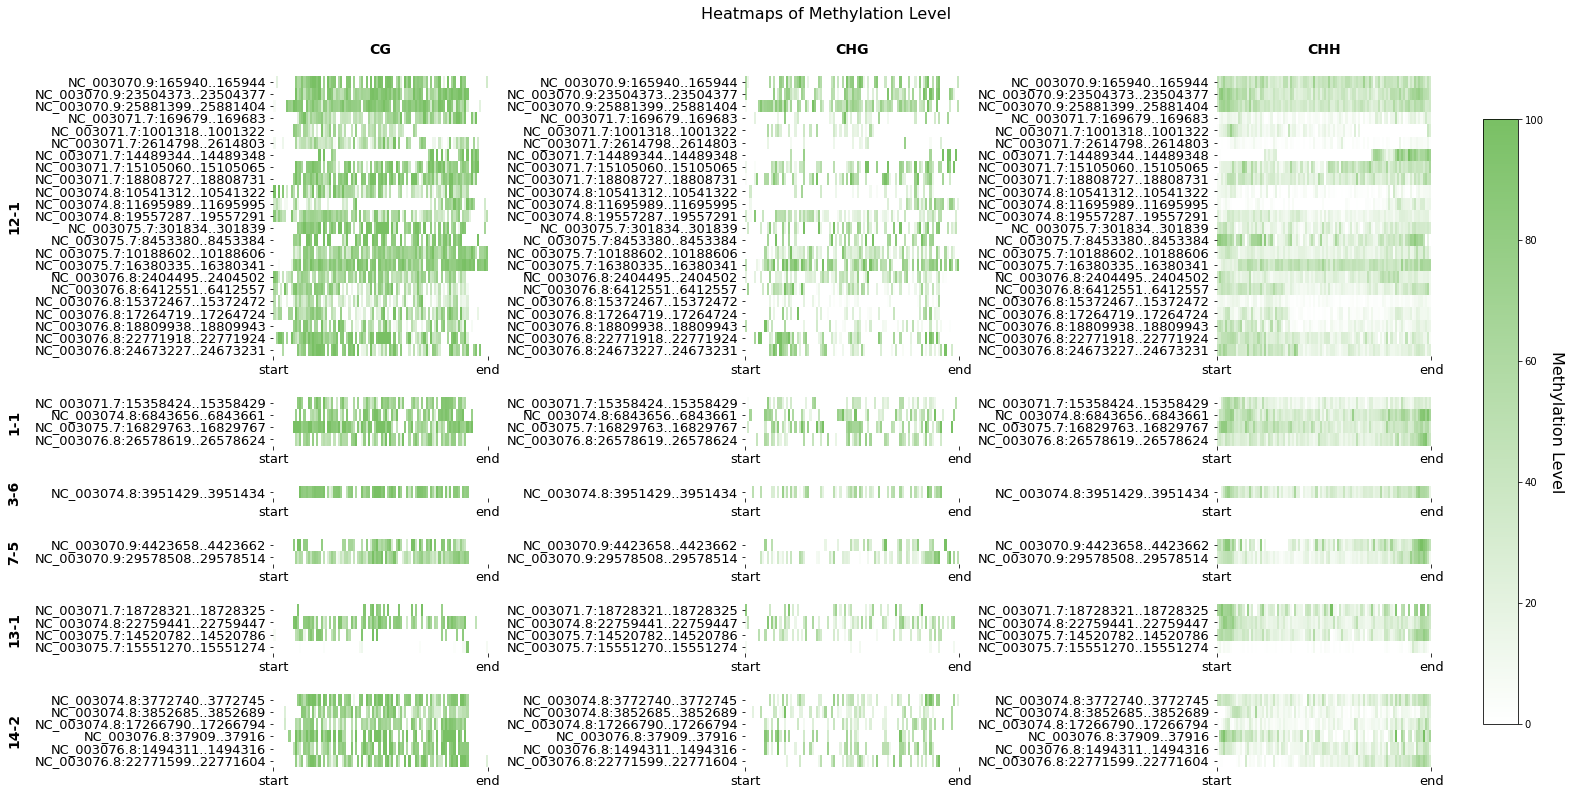

In [20]:
# Define global min and max values for the color scale
vmin = min(df.iloc[:, 7:].min().min() for df in matched_dfs.values())  # Global minimum value
vmax = max(df.iloc[:, 7:].max().max() for df in matched_dfs.values())  # Global maximum value

# Calculate heights for each subplot based on the number of rows in the DataFrame
heights = [len(df) for df in matched_dfs.values()][::3]  # Heights based on number of rows
total_height = sum(heights)  # Total height for normalization

# Create a figure with more space
fig = plt.figure(figsize=(24, 12))
fig.suptitle('Heatmaps of Methylation Level', fontsize=16, y=0.98)

# Create GridSpec with proper spacing
gs = fig.add_gridspec(6, 3, height_ratios=heights, hspace=0.5, wspace=1.2, 
                      left=0.18, right=0.85, top=0.9, bottom=0.1)

# Create axes using the GridSpec
axes = []
for i in range(6):
    for j in range(3):
        axes.append(fig.add_subplot(gs[i, j]))

# Define column titles (CG, CHG, CHH)
col_titles = ['CG', 'CHG', 'CHH']

# Define row titles (sample names)
row_titles = ['12-1', '1-1', '3-6', '7-5', '13-1', '14-2']  # Sample names from ins_dict

# Iterate through the results_diff_dict and plot each heatmap in a subplot
for i, (name, df) in enumerate(matched_dfs.items()):
    # Plot the heatmap in the current subplot
    heatmap = sns.heatmap(
        df.iloc[:, 7:], 
        cmap=wg_cmap, 
        ax=axes[i], 
        cbar=False,  # Disable individual color bars
        vmin=vmin,  # Use global min for color scale
        vmax=vmax   # Use global max for color scale
    )
    
    # Set y-ticks in the center of bins
    yticks = np.arange(len(df)) + 0.5  # Offset by 0.5 to center the ticks
    axes[i].set_yticks(yticks)
    axes[i].set_yticklabels(df['TEI'], fontsize=13, rotation=0, va='center')  # Use 'insertion' column for y-tick labels
    
    # Remove x and y labels
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    
    # Customize x-ticks
    axes[i].set_xticks([0, 100])  # Positions for -1000bp, TEI, +1000bp (aligned to edges)
    axes[i].set_xticklabels(['start', 'end'], fontsize=13, rotation=0)


# Get the positions of the subplots after they've been created
fig.canvas.draw()  # This is needed to ensure the positions are calculated
pos = []
for ax in axes:
    pos.append(ax.get_position())

# Add column titles (CG, CHG, CHH)
for j in range(3):
    # Calculate the center position for each column
    x_center = (pos[j].x0 + pos[j].x1) / 2
    fig.text(
        x_center, 0.93, col_titles[j],
        ha='center', va='center', fontsize=14, fontweight='bold'
    )

# Add row titles (sample names)
for k in range(6):
    # Calculate the center position for each row
    y_center = (pos[k*3].y0 + pos[k*3].y1) / 2
    fig.text(
        0.03, y_center, row_titles[k],
        ha='center', va='center', fontsize=14, fontweight='bold', rotation=90
    )

# Add a single color bar for the entire figure
cbar_ax = fig.add_axes([0.88, 0.15, 0.02, 0.7])  # Adjusted position for the color bar
cbar = plt.colorbar(heatmap.get_children()[0], cax=cbar_ax)
cbar.set_label('Methylation Level', rotation=270, labelpad=20, fontsize=16)
# Save the figure
plt.savefig('plots/TEIs_binned_methylation_filtered.svg', bbox_inches='tight', dpi=300)

## TEI flanks methylation difference

In [50]:
results_te_dict = {}

for key in ['12-1', '1-1', '3-6', '7-5', '13-1', '14-2']:
    for context in ['CG', 'CHG', 'CHH']:
        results_te_dict[f'{key}_{context}'] = pd.read_csv(f'TEI_flanks/{key}_{context}_flanking_methylation_2kb.csv')

In [ ]:
matched_dfs = {}

# Define a tolerance for start/end positions (e.g., ±5 bp)
TOLERANCE = 30
for key in ['12-1', '1-1', '3-6', '7-5', '13-1', '14-2']:
    df2 = match_dfs[key]

    # Add extracted coordinates to df2
    df2[['chr', 'start', 'end']] = df2['TEIcoord'].apply(extract_coords).apply(pd.Series)

    for context in ['CG', 'CHG', 'CHH']:
        df1 = results_te_dict[f'{key}_{context}'] 
        
        # Add extracted coordinates to df1
        df1[['chr', 'start', 'end']] = df1['insertion'].apply(extract_coords).apply(pd.Series)


        # Merge df1 and df2 based on fuzzy matching of coordinates
        merged_df = pd.merge(
            df1,
            df2,
            on='chr',  # Match by chromosome
            suffixes=('_df1', '_df2')
        )

        # Filter rows where start and end positions are within the tolerance
        merged_df = merged_df[
            (abs(merged_df['start_df1'] - merged_df['start_df2']) <= TOLERANCE) &
            (abs(merged_df['end_df1'] - merged_df['end_df2']) <= TOLERANCE)
        ]

        # Drop unnecessary columns
        merged_df = merged_df.drop(columns=['chr', 'start_df1', 'end_df1', 'start_df2', 'end_df2'])

        # Reorder columns for clarity
        merged_df = merged_df[['insertion', 'TEIcoord', 'sample', 'zygoticity', 'orientaion_TEI', 'orientation_gene', 'consistency'] + 
                        [col for col in merged_df.columns if col.startswith('bin_')]]
        merged_df.to_csv(f'TEI_flanks/{key}_{context}_flanking_methylation_2kb_ori.csv', index=False)
        matched_dfs[f'{key}_{context}'] = merged_df

In [52]:
results_col_dict = {}

for key in ['12-1_Col-0', '1-1_Col-0', '3-6_Col-0', '7-5_Col-0', '13-1_Col-0', '14-2_Col-0']:
    for context in ['CG', 'CHG', 'CHH']:
        results_col_dict[f'{key}_{context}'] = pd.read_csv(f'TEI_flanks/{key}_{context}_flanking_methylation_2kb.csv')

In [55]:
results_diff_dict = {}
results_dict = {}
results_col_dict_filt = {}


for df_1, df_2, df_name in zip(matched_dfs.values(), results_col_dict.values(), matched_dfs.keys()):

    df_2 = df_2[df_2['insertion'].isin(df_1['insertion'])].sort_values(by='insertion').reset_index(drop=True)
    df_1 = df_1.sort_values(by='insertion').reset_index(drop=True)

    ins = df_1['insertion'].values
    zygo = df_1['zygoticity'].values
    ori = df_1['orientaion_TEI'].values
    orig = df_1['orientation_gene'].values
    cons = df_1['consistency'].values

    df_1 = df_1.iloc[:, 7:]
    df_2 = df_2.iloc[:, :80]

    df_diff = df_1 - df_2
    df_diff['insertion'] = ins
    df_diff['zygoticity'] = zygo
    df_diff['orientation_TEI'] = ori
    df_diff['orientation_gene'] = orig
    df_diff['consistency'] = cons

    df_a = df_1
    df_a['insertion'] = ins
    df_a['zygoticity'] = zygo
    df_a['orientation_TEI'] = ori
    df_a['orientation_gene'] = orig
    df_a['consistency'] = cons

    df_b = df_2
    df_b['insertion'] = ins
    df_b['zygoticity'] = zygo
    df_b['orientation_TEI'] = ori
    df_b['orientation_gene'] = orig
    df_b['consistency'] = cons

    results_diff_dict[df_name] = df_diff
    results_dict[df_name] = df_a
    results_col_dict_filt[df_name] = df_b

    #print('OK')

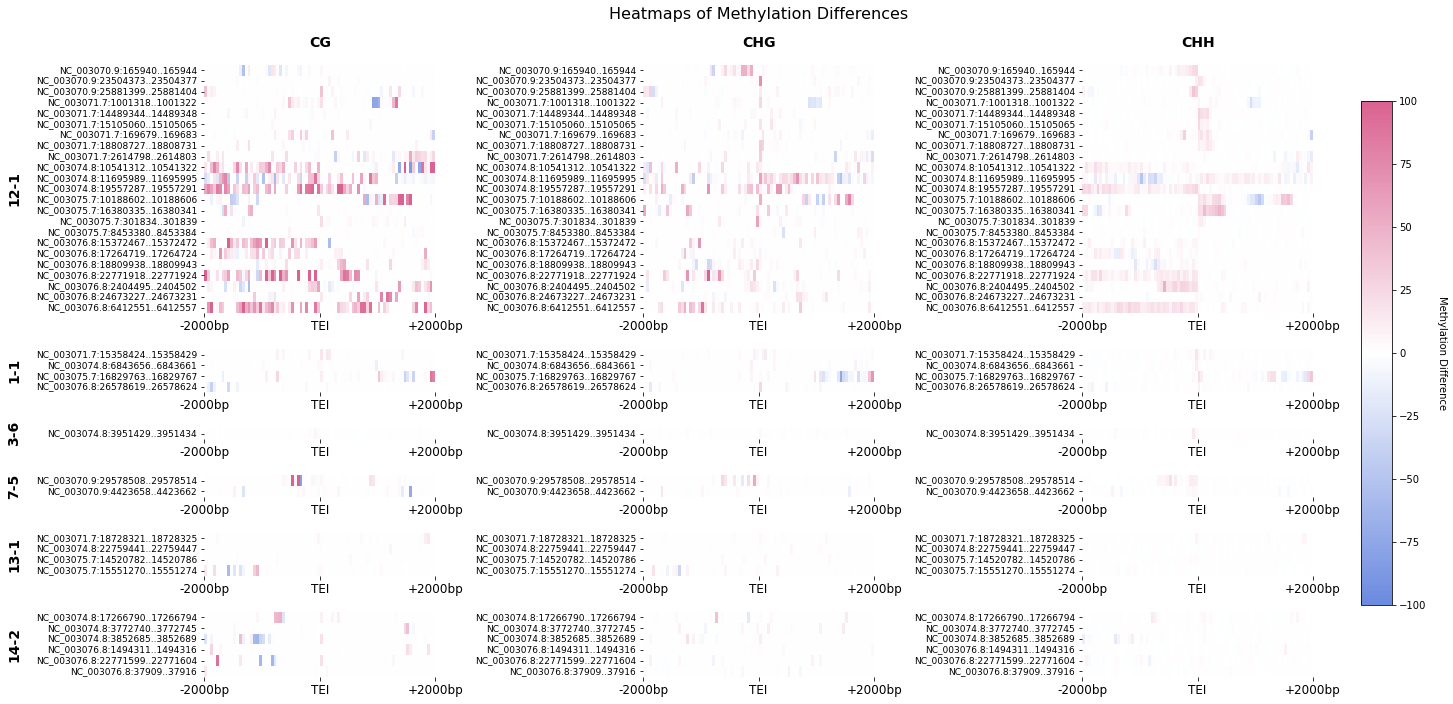

In [71]:
# Define global min and max values for the color scale
vmin = -100
vmax = 100

# Calculate heights for each subplot based on the number of rows in the DataFrame
heights = [len(df) for df in results_diff_dict.values()][::3]  # Heights based on number of rows
total_height = sum(heights)  # Total height for normalization

# Create a figure with more space
fig = plt.figure(figsize=(22, 10))
fig.suptitle('Heatmaps of Methylation Differences', fontsize=16, y=0.98)

# Create GridSpec with proper spacing
gs = fig.add_gridspec(6, 3, height_ratios=heights, hspace=0.5, wspace=0.9, 
                      left=0.15, right=0.85, top=0.9, bottom=0.05)

# Create axes using the GridSpec
axes = []
for i in range(6):
    for j in range(3):
        axes.append(fig.add_subplot(gs[i, j]))

# Define column titles (CG, CHG, CHH)
col_titles = ['CG', 'CHG', 'CHH']

# Define row titles (sample names)
row_titles = ['12-1', '1-1', '3-6', '7-5', '13-1', '14-2']  # Sample names from ins_dict

# Iterate through the results_diff_dict and plot each heatmap in a subplot
for i, (name, df) in enumerate(results_diff_dict.items()):
    # Plot the heatmap in the current subplot
    heatmap = sns.heatmap(
        df.iloc[:, :80], 
        cmap=bwp_cmap, 
        ax=axes[i], 
        cbar=False,  # Disable individual color bars
        vmin=vmin,  # Use global min for color scale
        vmax=vmax   # Use global max for color scale
    )
    
    # Set y-ticks in the center of bins
    yticks = np.arange(len(df)) + 0.5  # Offset by 0.5 to center the ticks
    axes[i].set_yticks(yticks)
    axes[i].set_yticklabels(df['insertion'], fontsize=9, rotation=0, va='center')  # Use 'insertion' column for y-tick labels
    
    # Remove x and y labels
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    
    # Customize x-ticks
    axes[i].set_xticks([0, 40, 80])  # Positions for -1000bp, TEI, +1000bp (aligned to edges)
    axes[i].set_xticklabels(['-2000bp', 'TEI', '+2000bp'], fontsize=12, rotation=0)

# Get the positions of the subplots after they've been created
fig.canvas.draw()  # This is needed to ensure the positions are calculated
pos = []
for ax in axes:
    pos.append(ax.get_position())

# Add column titles (CG, CHG, CHH)
for j in range(3):
    # Calculate the center position for each column
    x_center = (pos[j].x0 + pos[j].x1) / 2
    fig.text(
        x_center, 0.93, col_titles[j],
        ha='center', va='center', fontsize=14, fontweight='bold'
    )

# Add row titles (sample names)
for k in range(6):
    # Calculate the center position for each row
    y_center = (pos[k*3].y0 + pos[k*3].y1) / 2
    fig.text(
        0.03, y_center, row_titles[k],
        ha='center', va='center', fontsize=14, fontweight='bold', rotation=90
    )

# Add a single color bar for the entire figure
cbar_ax = fig.add_axes([0.88, 0.15, 0.02, 0.7])  # Adjusted position for the color bar
cbar = plt.colorbar(heatmap.get_children()[0], cax=cbar_ax)
cbar.set_label('Methylation Difference', rotation=270, labelpad=20)

# Save the figure
plt.savefig('plots/TEI_flanking_methylation_diff_2kb_filtered.svg', bbox_inches='tight', dpi=300)

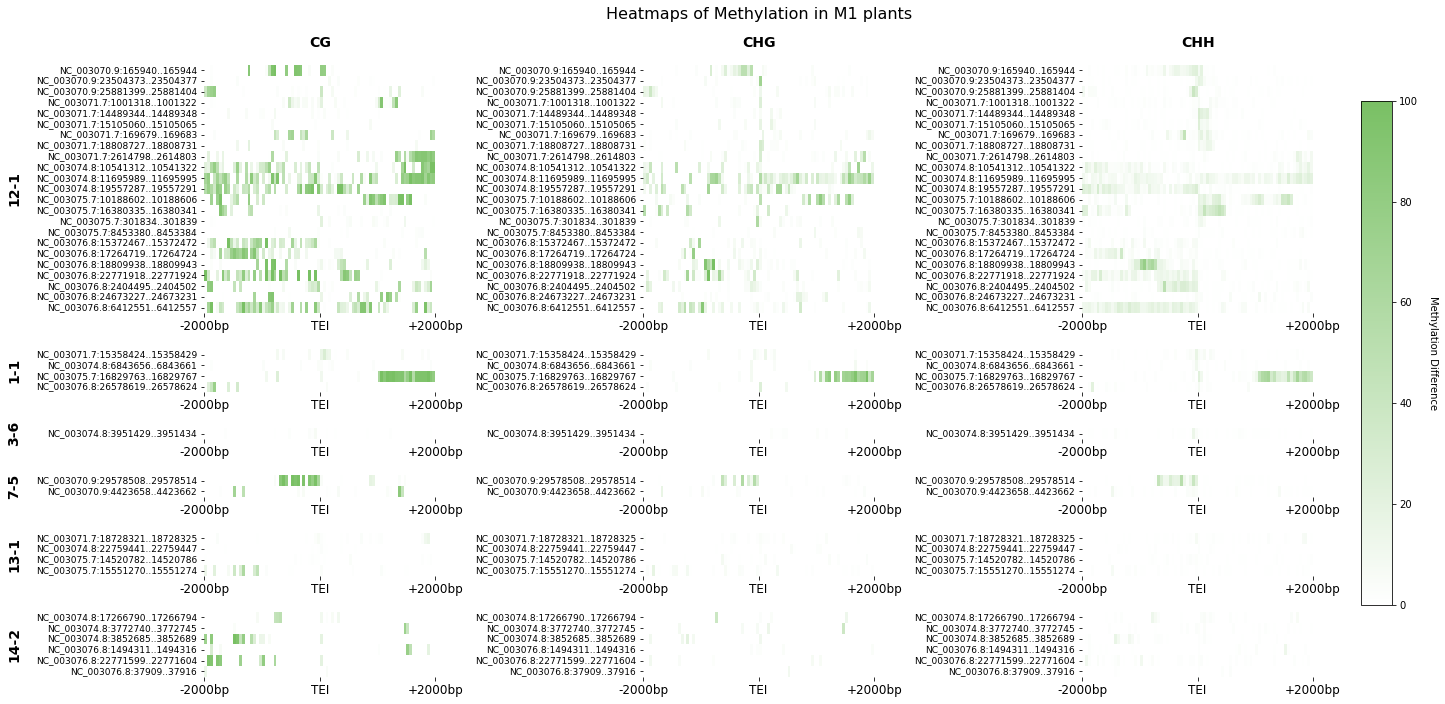

In [72]:
# Define global min and max values for the color scale
vmin = min(df.iloc[:, :80].min().min() for df in results_dict.values())  # Global minimum value
vmax = max(df.iloc[:, :80].max().max() for df in results_dict.values())  # Global maximum value

# Calculate heights for each subplot based on the number of rows in the DataFrame
heights = [len(df) for df in results_dict.values()][::3]  # Heights based on number of rows
total_height = sum(heights)  # Total height for normalization

# Create a figure with more space
fig = plt.figure(figsize=(22, 10))
fig.suptitle('Heatmaps of Methylation in M1 plants', fontsize=16, y=0.98)

# Create GridSpec with proper spacing
gs = fig.add_gridspec(6, 3, height_ratios=heights, hspace=0.5, wspace=0.9, 
                      left=0.15, right=0.85, top=0.9, bottom=0.05)

# Create axes using the GridSpec
axes = []
for i in range(6):
    for j in range(3):
        axes.append(fig.add_subplot(gs[i, j]))

# Define column titles (CG, CHG, CHH)
col_titles = ['CG', 'CHG', 'CHH']

# Define row titles (sample names)
row_titles = ['12-1', '1-1', '3-6', '7-5', '13-1', '14-2']  # Sample names from ins_dict

# Iterate through the results_diff_dict and plot each heatmap in a subplot
for i, (name, df) in enumerate(results_dict.items()):
    # Plot the heatmap in the current subplot
    heatmap = sns.heatmap(
        df.iloc[:, :80], 
        cmap=wg_cmap, 
        ax=axes[i], 
        cbar=False,  # Disable individual color bars
        vmin=vmin,  # Use global min for color scale
        vmax=vmax   # Use global max for color scale
    )
    
    # Set y-ticks in the center of bins
    yticks = np.arange(len(df)) + 0.5  # Offset by 0.5 to center the ticks
    axes[i].set_yticks(yticks)
    axes[i].set_yticklabels(df['insertion'], fontsize=9, rotation=0, va='center')  # Use 'insertion' column for y-tick labels
    
    # Remove x and y labels
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    
    # Customize x-ticks
    axes[i].set_xticks([0, 40, 80])  # Positions for -1000bp, TEI, +1000bp (aligned to edges)
    axes[i].set_xticklabels(['-2000bp', 'TEI', '+2000bp'], fontsize=12, rotation=0)

# Get the positions of the subplots after they've been created
fig.canvas.draw()  # This is needed to ensure the positions are calculated
pos = []
for ax in axes:
    pos.append(ax.get_position())

# Add column titles (CG, CHG, CHH)
for j in range(3):
    # Calculate the center position for each column
    x_center = (pos[j].x0 + pos[j].x1) / 2
    fig.text(
        x_center, 0.93, col_titles[j],
        ha='center', va='center', fontsize=14, fontweight='bold'
    )

# Add row titles (sample names)
for k in range(6):
    # Calculate the center position for each row
    y_center = (pos[k*3].y0 + pos[k*3].y1) / 2
    fig.text(
        0.03, y_center, row_titles[k],
        ha='center', va='center', fontsize=14, fontweight='bold', rotation=90
    )

# Add a single color bar for the entire figure
cbar_ax = fig.add_axes([0.88, 0.15, 0.02, 0.7])  # Adjusted position for the color bar
cbar = plt.colorbar(heatmap.get_children()[0], cax=cbar_ax)
cbar.set_label('Methylation Difference', rotation=270, labelpad=20)

# Save the figure
plt.savefig('plots/TEI_flanking_methylation_2kb_filtered.svg', bbox_inches='tight', dpi=300)

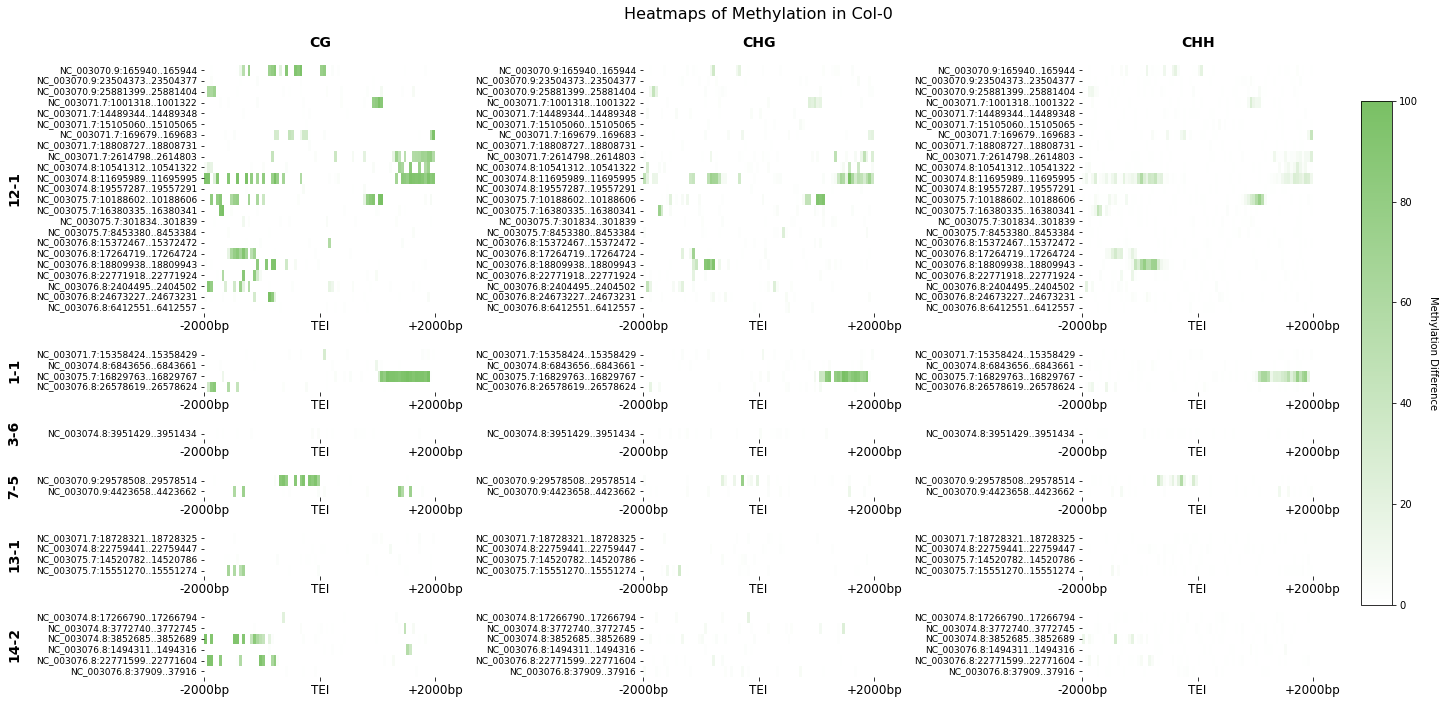

In [73]:
# Define global min and max values for the color scale
vmin = min(df.iloc[:, :80].min().min() for df in results_col_dict_filt.values())  # Global minimum value
vmax = max(df.iloc[:, :80].max().max() for df in results_col_dict_filt.values())  # Global maximum value

# Calculate heights for each subplot based on the number of rows in the DataFrame
heights = [len(df) for df in results_col_dict_filt.values()][::3]  # Heights based on number of rows
total_height = sum(heights)  # Total height for normalization

# Create a figure with more space
fig = plt.figure(figsize=(22, 10))
fig.suptitle('Heatmaps of Methylation in Col-0', fontsize=16, y=0.98)

# Create GridSpec with proper spacing
gs = fig.add_gridspec(6, 3, height_ratios=heights, hspace=0.5, wspace=0.9, 
                      left=0.15, right=0.85, top=0.9, bottom=0.05)

# Create axes using the GridSpec
axes = []
for i in range(6):
    for j in range(3):
        axes.append(fig.add_subplot(gs[i, j]))

# Define column titles (CG, CHG, CHH)
col_titles = ['CG', 'CHG', 'CHH']

# Define row titles (sample names)
row_titles = ['12-1', '1-1', '3-6', '7-5', '13-1', '14-2']  # Sample names from ins_dict

# Iterate through the results_diff_dict and plot each heatmap in a subplot
for i, (name, df) in enumerate(results_col_dict_filt.items()):
    # Plot the heatmap in the current subplot
    heatmap = sns.heatmap(
        df.iloc[:, :80], 
        cmap=wg_cmap, 
        ax=axes[i], 
        cbar=False,  # Disable individual color bars
        vmin=vmin,  # Use global min for color scale
        vmax=vmax   # Use global max for color scale
    )
    
    # Set y-ticks in the center of bins
    yticks = np.arange(len(df)) + 0.5  # Offset by 0.5 to center the ticks
    axes[i].set_yticks(yticks)
    axes[i].set_yticklabels(df['insertion'], fontsize=9, rotation=0, va='center')  # Use 'insertion' column for y-tick labels
    
    # Remove x and y labels
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    
    # Customize x-ticks
    axes[i].set_xticks([0, 40, 80])  # Positions for -1000bp, TEI, +1000bp (aligned to edges)
    axes[i].set_xticklabels(['-2000bp', 'TEI', '+2000bp'], fontsize=12, rotation=0)

# Get the positions of the subplots after they've been created
fig.canvas.draw()  # This is needed to ensure the positions are calculated
pos = []
for ax in axes:
    pos.append(ax.get_position())

# Add column titles (CG, CHG, CHH)
for j in range(3):
    # Calculate the center position for each column
    x_center = (pos[j].x0 + pos[j].x1) / 2
    fig.text(
        x_center, 0.93, col_titles[j],
        ha='center', va='center', fontsize=14, fontweight='bold'
    )

# Add row titles (sample names)
for k in range(6):
    # Calculate the center position for each row
    y_center = (pos[k*3].y0 + pos[k*3].y1) / 2
    fig.text(
        0.03, y_center, row_titles[k],
        ha='center', va='center', fontsize=14, fontweight='bold', rotation=90
    )

# Add a single color bar for the entire figure
cbar_ax = fig.add_axes([0.88, 0.15, 0.02, 0.7])  # Adjusted position for the color bar
cbar = plt.colorbar(heatmap.get_children()[0], cax=cbar_ax)
cbar.set_label('Methylation Difference', rotation=270, labelpad=20)

# Save the figure
plt.savefig('plots/TEI_flanking_methylation_Col_2kb_filtered.svg', bbox_inches='tight', dpi=300)

### For 12-1 only

In [66]:
results_diff_dict_121 = {k: v for k,v in results_diff_dict.items() if k in ['12-1_CG', '12-1_CHG', '12-1_CHH']}

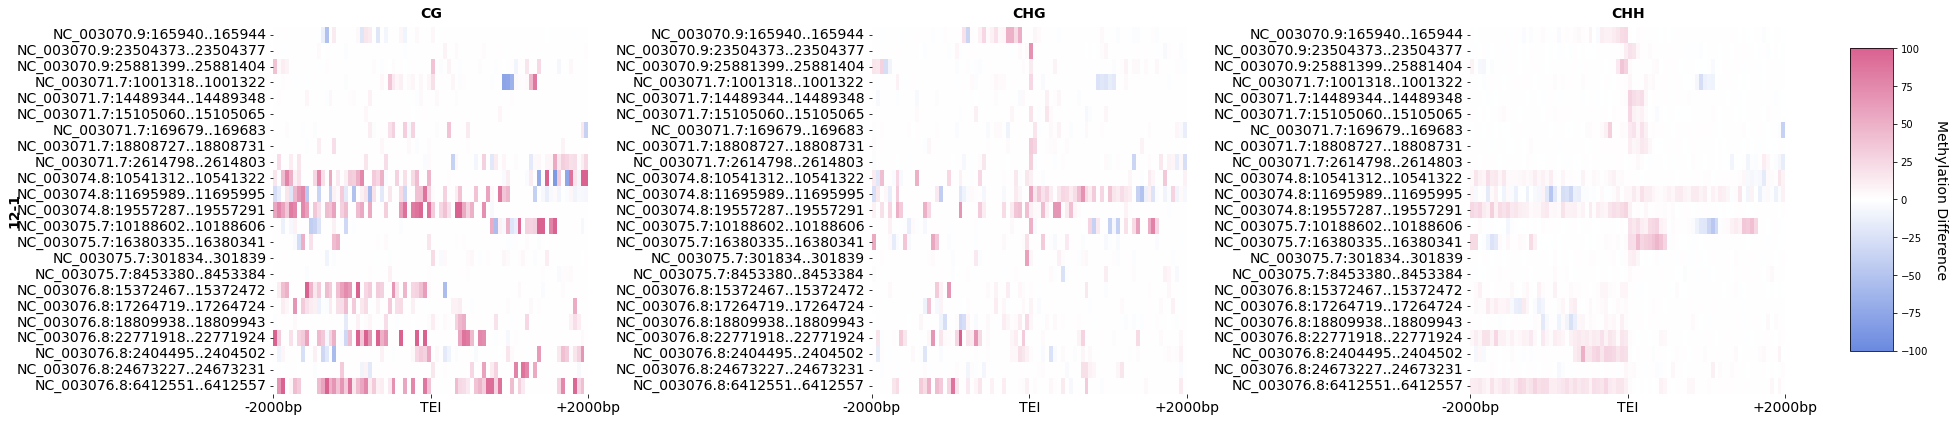

In [68]:
# Define global min and max values for the color scale
vmin = -100  # Global minimum value
vmax = 100 # Global maximum value

# Calculate heights for each subplot based on the number of rows in the DataFrame
heights = [len(df) for df in results_diff_dict_121.values()][::3]  # Heights based on number of rows
total_height = sum(heights)  # Total height for normalization

# Create a figure with more space
fig = plt.figure(figsize=(30, 6))
# fig.suptitle('Heatmaps of Methylation Differences', fontsize=16, y=0.98)

# Create GridSpec with proper spacing
gs = fig.add_gridspec(1, 3, height_ratios=heights, hspace=0.9, wspace=0.9, 
                      left=0.15, right=0.85, top=0.9, bottom=0.05)

# Create axes using the GridSpec
axes = []
for i in range(1):
    for j in range(3):
        axes.append(fig.add_subplot(gs[i, j]))

# Define column titles (CG, CHG, CHH)
col_titles = ['CG', 'CHG', 'CHH']

# Define row titles (sample names)
row_titles = ['12-1']  # Sample names from ins_dict

# Iterate through the results_diff_dict and plot each heatmap in a subplot
for i, (name, df) in enumerate(results_diff_dict_121.items()):
    # Plot the heatmap in the current subplot
    heatmap = sns.heatmap(
        df.iloc[:, :80], 
        cmap=bwp_cmap, 
        ax=axes[i], 
        cbar=False,  # Disable individual color bars
        vmin=vmin,  # Use global min for color scale
        vmax=vmax   # Use global max for color scale
    )
    
    # Set y-ticks in the center of bins
    yticks = np.arange(len(df)) + 0.5  # Offset by 0.5 to center the ticks
    axes[i].set_yticks(yticks)
    axes[i].set_yticklabels(df['insertion'], fontsize=14, rotation=0, va='center')  # Use 'insertion' column for y-tick labels
    
    # Remove x and y labels
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    
    # Customize x-ticks
    axes[i].set_xticks([0, 40, 80])  # Positions for -1000bp, TEI, +1000bp (aligned to edges)
    axes[i].set_xticklabels(['-2000bp', 'TEI', '+2000bp'], fontsize=14, rotation=0)

# Get the positions of the subplots after they've been created
fig.canvas.draw()  # This is needed to ensure the positions are calculated
pos = []
for ax in axes:
    pos.append(ax.get_position())

# Add column titles (CG, CHG, CHH)
for j in range(3):
    # Calculate the center position for each column
    x_center = (pos[j].x0 + pos[j].x1) / 2
    fig.text(
        x_center, 0.93, col_titles[j],
        ha='center', va='center', fontsize=14, fontweight='bold'
    )

# Add row titles (sample names)
for k in range(1):
    # Calculate the center position for each row
    y_center = (pos[k*3].y0 + pos[k*3].y1) / 2
    fig.text(
        0.03, y_center, row_titles[k],
        ha='center', va='center', fontsize=14, fontweight='bold', rotation=90
    )

# Add a single color bar for the entire figure
cbar_ax = fig.add_axes([0.88, 0.15, 0.02, 0.7])  # Adjusted position for the color bar
cbar = plt.colorbar(heatmap.get_children()[0], cax=cbar_ax)
cbar.set_label('Methylation Difference', rotation=270, labelpad=20, fontsize=14)

# Save the figure
plt.savefig('plots/TEI_flanking_methylation_diff_2kb_12-1.svg', bbox_inches='tight', dpi=300)

In [69]:
results_diff_dict_121 = {k: v for k,v in results_diff_dict.items() if k in ['12-1_CHH']}

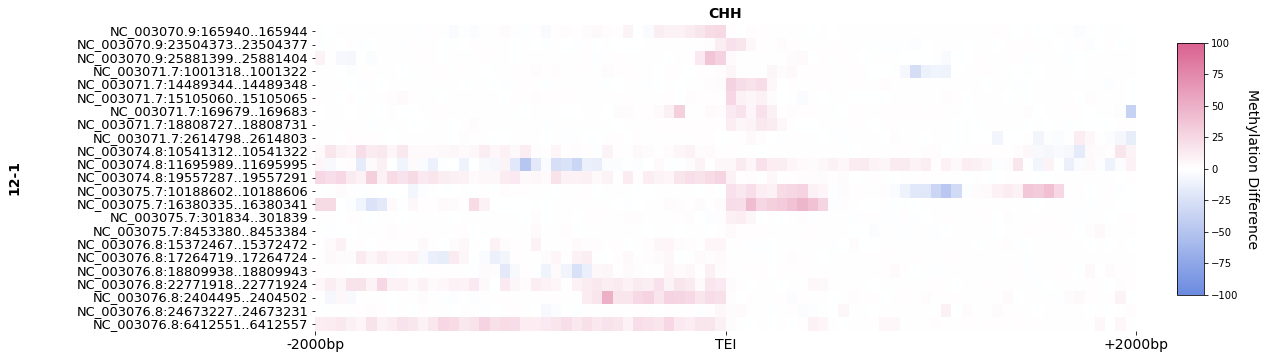

In [70]:
# Define global min and max values for the color scale
vmin = -100  # Global minimum value
vmax = 100  # Global maximum value

# Calculate heights for each subplot based on the number of rows in the DataFrame
heights = [len(df) for df in results_diff_dict_121.values()][::3]  # Heights based on number of rows
total_height = sum(heights)  # Total height for normalization

# Create a figure with more space
fig = plt.figure(figsize=(19, 5))
# fig.suptitle('Heatmaps of Methylation Differences', fontsize=16, y=0.98)

# Create GridSpec with proper spacing
gs = fig.add_gridspec(1, 1, height_ratios=heights, hspace=0.9, wspace=0.9, 
                      left=0.25, right=0.85, top=0.9, bottom=0.05)

# Create axes using the GridSpec
axes = []
for i in range(1):
    for j in range(1):
        axes.append(fig.add_subplot(gs[i, j]))

# Define column titles (CG, CHG, CHH)
col_titles = ['CHH']

# Define row titles (sample names)
row_titles = ['12-1']  # Sample names from ins_dict

# Iterate through the results_diff_dict and plot each heatmap in a subplot
for i, (name, df) in enumerate(results_diff_dict_121.items()):
    # Plot the heatmap in the current subplot
    heatmap = sns.heatmap(
        df.iloc[:, :80], 
        cmap=bwp_cmap, 
        ax=axes[i], 
        cbar=False,  # Disable individual color bars
        vmin=vmin,  # Use global min for color scale
        vmax=vmax   # Use global max for color scale
    )
    
    # Set y-ticks in the center of bins
    yticks = np.arange(len(df)) + 0.5  # Offset by 0.5 to center the ticks
    axes[i].set_yticks(yticks)
    axes[i].set_yticklabels(df['insertion'], fontsize=13, rotation=0, va='center')  # Use 'insertion' column for y-tick labels
    
    # Remove x and y labels
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    
    # Customize x-ticks
    axes[i].set_xticks([0, 40, 80])  # Positions for -1000bp, TEI, +1000bp (aligned to edges)
    axes[i].set_xticklabels(['-2000bp', 'TEI', '+2000bp'], fontsize=14, rotation=0)

# Get the positions of the subplots after they've been created
fig.canvas.draw()  # This is needed to ensure the positions are calculated
pos = []
for ax in axes:
    pos.append(ax.get_position())

# Add column titles (CG, CHG, CHH)
for j in range(1):
    # Calculate the center position for each column
    x_center = (pos[j].x0 + pos[j].x1) / 2
    fig.text(
        x_center, 0.93, col_titles[j],
        ha='center', va='center', fontsize=14, fontweight='bold'
    )

# Add row titles (sample names)
for k in range(1):
    # Calculate the center position for each row
    y_center = (pos[k*3].y0 + pos[k*3].y1) / 2
    fig.text(
        0.03, y_center, row_titles[k],
        ha='center', va='center', fontsize=14, fontweight='bold', rotation=90
    )

# Add a single color bar for the entire figure
cbar_ax = fig.add_axes([0.88, 0.15, 0.02, 0.7])  # Adjusted position for the color bar
cbar = plt.colorbar(heatmap.get_children()[0], cax=cbar_ax)
cbar.set_label('Methylation Difference', rotation=270, labelpad=20, fontsize=14)

# Save the figure
plt.savefig('plots/TEI_flanking_methylation_diff_2kb_12-1_CHH.svg', bbox_inches='tight', dpi=300)